# Produced a Gaussian distribution in all degrees of freedom

In [1]:
import generatorTool as gt
import numpy as np
import numpy.random as rd 
import matplotlib.pyplot as plt
from scipy import constants
import makeopenpmd
import h5py    
import openpmd_api as io
import importlib

# unit conversion:
mm       = 1e3

qElec    = constants.value(u'elementary charge')
mElec    = constants.value(u'electron mass')
qOm      = qElec/mElec
cLight   = constants.value(u'speed of light in vacuum')

epsilon0 = constants.epsilon_0
mu0      = constants.mu_0


### Beam parameters setup

##### general parameters

In [2]:
n            = 100000 # number of macroparticles
lorentz_fac  = 120    # Lorentz factor
norm_emitx   = 5e-6   # normalized emittance in x
norm_emity   = 5e-6   # normalized emittance in y
nsigma       = 3      # cut [in # of sigmas] for the Gaussian distrib.
bunchCharge  =-1e-9

#### Compute Courant-Snyder parameter to focus the beam after a drift of D 

In [3]:
D         = 0.188/2  # location of waist
sizeStar  = 1.e-4  # RMS beam size at waist
betaxStar = (sizeStar)**2/(norm_emitx/lorentz_fac)
betayStar = (sizeStar)**2/(norm_emity/lorentz_fac)

betax     = betaxStar+D**2/betaxStar
betay     = betayStar+D**2/betayStar

alphax    = D/betaxStar
alphay    = D/betayStar

gammax    = (1+alphax**2)/betax
gammay    = (1+alphay**2)/betay

print ("betax* [m] = ",betaxStar)
print ("betax  [m] = ",betax)
print ("alphax [-] = ",alphax)
print ("betay  [m] = ",betay)
print ("alphay [-] = ",alphay)


betax* [m] =  0.24
betax  [m] =  0.27681666666666666
alphax [-] =  0.39166666666666666
betay  [m] =  0.27681666666666666
alphay [-] =  0.39166666666666666


Text(0, 0.5, 'RMS beam sizes (m)')

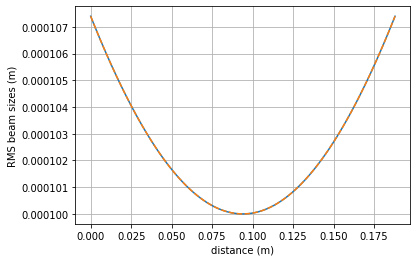

In [4]:
# check envelop
sCoor = np.linspace(0,2*D,101)

sigmX = np.sqrt((norm_emitx/lorentz_fac)*(betax+2*sCoor*(-alphax)+gammax*sCoor**2))
sigmY = np.sqrt((norm_emity/lorentz_fac)*(betay+2*sCoor*(-alphay)+gammay*sCoor**2))

plt.plot (sCoor,sigmX)
plt.plot (sCoor,sigmY,'--')
#plt.plot (sCoor,3*sigmX)
#plt.plot (sCoor,3*sigmY,'--')
plt.grid()
plt.xlabel ('distance (m)')
plt.ylabel ('RMS beam sizes (m)')


#### longitudinal phase space

In [5]:
sigmaIncdpp  = 1e-3  # RMS relative incoherent energy spread 
sigmaz       = 1e-3  # RMS bunch lengh
ddOverdz     = 0.0   # in m^-1 -- chirp (slope)


### Generating the simulation

In [6]:
import importlib
importlib.reload(gt)
# generate the Gaussian distribution in (x,x',y,y')
emitgeomx=norm_emitx/lorentz_fac
emitgeomy=norm_emity/lorentz_fac

x, xp, y, yp, z, dpp = gt.gaussian_phase_space_3dof(n, \
                                  alphax, betax, emitgeomx,\
                                  alphay, betay, emitgeomy, \
                                  sigmaz, sigmaIncdpp, ddOverdz, \
                                  nsigma, keeper='ell')  



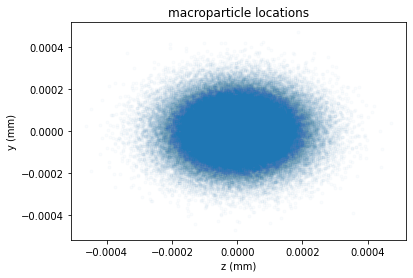

In [7]:
# check the distribution cut is elliptical or square
plt.plot(x,y,'.', alpha=0.02)
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.title ('macroparticle locations')
plt.show()


#### plotting the results

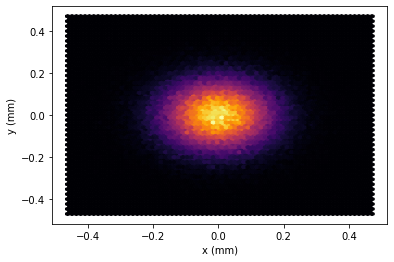

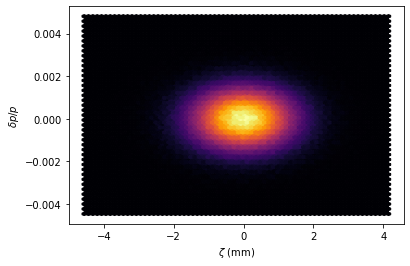

In [8]:
plt.hexbin (mm*x,mm*y, gridsize=70, cmap='inferno')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()
plt.hexbin (mm*z,dpp, gridsize=70, cmap='inferno')
#plt.plot (z,dpp,'.')
plt.xlabel(r'$\zeta$ (mm)')
plt.ylabel(r'$\delta p/p$ ')
plt.show()


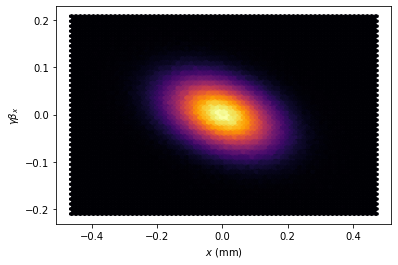

In [9]:
plt.hexbin (mm*x,xp*(1+dpp)*lorentz_fac, gridsize=70, cmap='inferno')
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'$\gamma\beta_x$')
plt.show()

### Saving to file in openPMD



In [10]:
# rewrite the momentum in units of gamma*beta_i 
# (assume relativistic beam here)/


px=xp*(1+dpp)*lorentz_fac
py=yp*(1+dpp)*lorentz_fac
pz=(1+dpp)*lorentz_fac

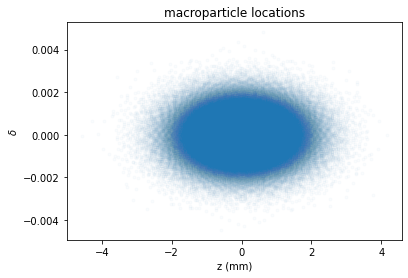

In [11]:
plt.plot (z*1e3,dpp,'.',alpha=0.02)
plt.xlabel('z (mm)')
plt.ylabel('$\delta$ ')
plt.title ('macroparticle locations')
plt.show()

In [14]:
# dump into a warpX-readable file
# warpX wants SI units so
importlib.reload(makeopenpmd)
px *= mElec*cLight
py *= mElec*cLight
pz *= mElec*cLight

makeopenpmd.make_openPMD(x, y, z, px, py, pz, 'init.h5', bunchCharge)


number of macroparticle: 100000


## check h5 file using openPMD-API tools

In [15]:
series = io.Series("init.h5", io.Access.read_only)

In [16]:
i = series.iterations[0]


In [17]:
for ps in i.particles:
    print("\t {0}".format(ps))
    print("With records:")
    for r in i.particles[ps]:
        print("\t {0}".format(r))

	 myparticle
With records:
	 charge
	 mass
	 momentum
	 position
	 positionOffset
	 weighting


In [18]:
electrons = i.particles["myparticle"]

In [22]:
charge = electrons["charge"][io.Mesh_Record_Component.SCALAR]
ww     = electrons["weighting"][io.Mesh_Record_Component.SCALAR]
series.flush()


array([1.e-09, 1.e-09, 1.e-09, ..., 1.e-09, 1.e-09, 1.e-09])

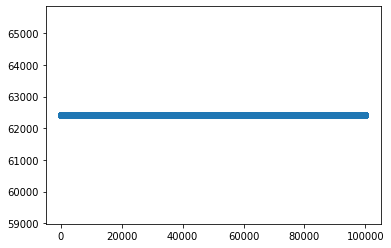

In [25]:
plt.plot (ww,'o')
np.shape(ww)
np.sum(charge)*ww